# Global Argo Dataset

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
from xhistogram.xarray import histogram
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
from flox.xarray import xarray_reduce

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff

In [3]:
# Set title size
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16  # Titles larger

# Set axis label size
plt.rcParams['axes.labelsize'] = 14  # Labels slightly smaller

This notebook is for binning the global argo dataset which includes all profiles that meet the following criteria:
- have salinity variable (others weeded out using my edits to the `to_xarray()` method in argopy)
- have at least 5 measurements (this is a requirement of argopy's `interp_std_levels()` method)
- have a max pressure greater than the min pressure (very small number of floats seemed to have unordered depths?)

The resulting dataset should have all the available data, including for profiles that don't reach 2000m. Argopy's `interp_std_levels()` method requires a profile has sampled to the maximum value in the interpolated depth grid, so when I was loading a box using `np.arange(0,2002,2)` only profiles that sampled to 2002m were being included. I've reworked my interpolation method to give `interp_std_levels()` a depth grid fitted to the max depth of that individual profile, then concatonated all of these profiles together (filing in nan values as necessary).

## Bin Data

In [4]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/new_test.nc', chunks={'N_PROF':10000})

In [5]:
ds = ds.assign_attrs({"Fetched_uri":''})
unique_prof = np.arange(len(ds['N_PROF']))
ds = ds.assign_coords(N_PROF=('N_PROF', unique_prof))
ds

<xarray.Dataset> Size: 123GB
Dimensions:            (PRES_INTERPOLATED: 1001, N_PROF: 2550896)
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1996 1998 2000
    TIME               (N_PROF) datetime64[ns] 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    LATITUDE           (N_PROF) float64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    LONGITUDE          (N_PROF) float64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
  * N_PROF             (N_PROF) int64 20MB 0 1 2 3 ... 2550893 2550894 2550895
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    CYCLE_NUMBER       (N_PROF) int64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    DATA_MODE          (N_PROF) <U1 10MB dask.array<chunksize=(10000,), meta=np.ndarray>
    DIRECTION          (N_PROF) <U1 10MB dask.array<chunksize=(10000,), meta=np.ndarray>
    PLATFORM_NUMBER    (N_PROF) int64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    PRES               (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    SA                 (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [ ]:
sample_max = 2.5

ds = ds.sortby('LATITUDE').persist()
boolean_indexer = (ds.sample_rate < sample_max).compute()
ds = ds.where(boolean_indexer, drop=True)

In [290]:
#ds = ds.where(ds.LATITUDE>-67.5, drop=True).where(ds.LATITUDE<67.5, drop=True)

In [291]:
latitude_expanded = np.tile(ds.LATITUDE.values[:, np.newaxis], (1, ds.PRES_INTERPOLATED.size))

In [292]:
n2 = gsw.Nsquared(ds.SA, ds.CT, ds.PRES, latitude_expanded, axis=1)

/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/gsw/stability.py:86: RuntimeWarning: divide by zero encountered in divide
  N2 = ((g_local**2) / (specvol_mid * db_to_pa * dp))


In [293]:
n2_padded = np.pad(n2[0], ((0, 0), (0, 1)), constant_values=np.nan)

In [294]:
ds['N2'] = xr.DataArray(n2_padded, dims=('N_PROF', 'PRES_INTERPOLATED'))

In [ ]:
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-67.5,68,3)

In [ ]:
def get_ds_binned(ds, lon_bins, lat_bins):
    
    ds_binned = xarray_reduce(
    ds,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)
    
    lon_l = np.arange(lon_bins[0],lon_bins[-1],3)
    lon_r = np.arange(lon_bins[1],lon_bins[-1]+1,3)
    lon_c = (lon_l + lon_r)/2

    lat_l = np.arange(lat_bins[0],lat_bins[-1],3)
    lat_r = np.arange(lat_bins[1],lat_bins[-1]+1,3)
    lat_c = (lat_l + lat_r)/2

    ds_binned = ds_binned.assign_coords({
        "lat_c": ("LATITUDE_bins", lat_c),
        "lat_l": ("LATITUDE_bins", lat_l),
        "lat_r": ("LATITUDE_bins", lat_r),
        "lon_c": ("LONGITUDE_bins", lon_c),
        "lon_l": ("LONGITUDE_bins", lon_l),
        "lon_r": ("LONGITUDE_bins", lon_r),
    })
    
    ds_binned = ds_binned.swap_dims({"LATITUDE_bins": "lat_c", "LONGITUDE_bins": "lon_c"})
    ds_binned = ds_binned.drop_vars(["LATITUDE_bins", "LONGITUDE_bins"])
    
    if isinstance(ds_binned, xr.Dataset):
        # For xarray.Dataset, use rename_dims and rename_vars
        ds_binned = ds_binned.rename_dims({"PRES_INTERPOLATED": "z_c"}).rename_vars({"PRES_INTERPOLATED": "z_c"})
    elif isinstance(ds_binned, xr.DataArray):
        # For xarray.DataArray, use rename to rename the dimension
        ds_binned = ds_binned.rename({"PRES_INTERPOLATED": "z_c"})
    else:
        raise TypeError("Input must be an xarray.Dataset or xarray.DataArray")

    
    return ds_binned

In [297]:
ds_binned = get_ds_binned(ds, lon_bins, lat_bins)

In [298]:
ds_binned

<xarray.Dataset> Size: 476MB
Dimensions:          (z_c: 1001, lon_c: 120, lat_c: 45)
Coordinates:
  * z_c              (z_c) int64 8kB 0 2 4 6 8 10 ... 1992 1994 1996 1998 2000
  * lat_c            (lat_c) float64 360B -66.0 -63.0 -60.0 ... 60.0 63.0 66.0
    lat_l            (lat_c) float64 360B -67.5 -64.5 -61.5 ... 58.5 61.5 64.5
    lat_r            (lat_c) float64 360B -64.5 -61.5 -58.5 ... 61.5 64.5 67.5
  * lon_c            (lon_c) float64 960B -178.5 -175.5 -172.5 ... 175.5 178.5
    lon_l            (lon_c) int64 960B -180 -177 -174 -171 ... 168 171 174 177
    lon_r            (lon_c) int64 960B -177 -174 -171 -168 ... 171 174 177 180
Data variables: (12/13)
    CT               (z_c, lon_c, lat_c) float64 43MB dask.array<chunksize=(1001, 1, 45), meta=np.ndarray>
    CYCLE_NUMBER     (z_c, lon_c, lat_c) float64 43MB dask.array<chunksize=(1001, 1, 45), meta=np.ndarray>
    DATA_MODE        (z_c, lon_c, lat_c) float64 43MB dask.array<chunksize=(1001, 1, 45), meta=np.ndarray>
    DIRECTION        (z_c, lon_c, lat_c) float64 43MB dask.array<chunksize=(1001, 1, 45), meta=np.ndarray>
    PLATFORM_NUMBER  (z_c, lon_c, lat_c) float64 43MB dask.array<chunksize=(1001, 1, 45), meta=np.ndarray>
    PRES             (z_c, lon_c, lat_c) float32 22MB dask.array<chunksize=(1001, 1, 45), meta=np.ndarray>
    ...               ...
    SA               (z_c, lon_c, lat_c) float64 43MB dask.array<chunksize=(1001, 1, 45), meta=np.ndarray>
    SIG0             (z_c, lon_c, lat_c) float64 43MB dask.array<chunksize=(1001, 1, 45), meta=np.ndarray>
    TEMP             (z_c, lon_c, lat_c) float32 22MB dask.array<chunksize=(1001, 1, 45), meta=np.ndarray>
    sample_rate      (z_c, lon_c, lat_c) float32 22MB dask.array<chunksize=(1001, 1, 45), meta=np.ndarray>
    SPICE            (z_c, lon_c, lat_c) float64 43MB dask.array<chunksize=(1001, 1, 45), meta=np.ndarray>
    N2               (z_c, lon_c, lat_c) float64 43MB 6.981e-07 4.24e-06 ... nan
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

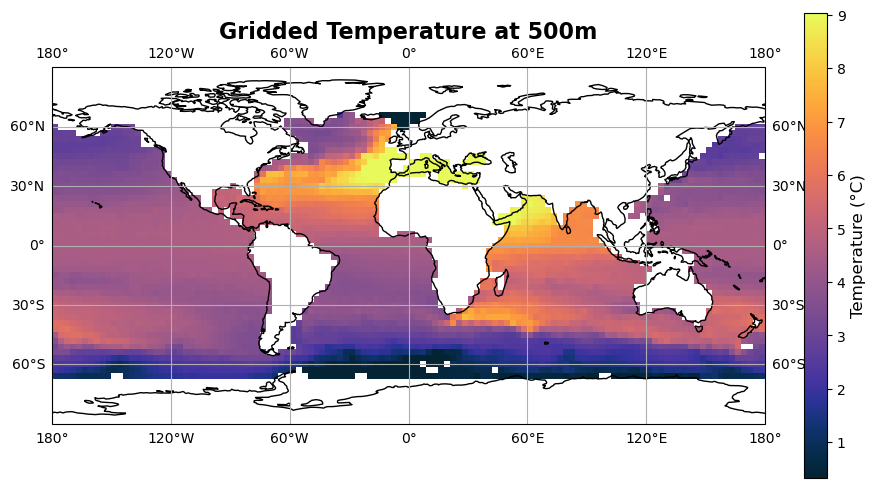

In [299]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

plot = ds_binned.CT.isel(z_c=500).plot(
    ax=ax, x='lon_c', y='lat_c', cmap=cmo.thermal, add_colorbar=False, robust=True)

cbar = plt.colorbar(plot, ax=ax, fraction=0.03, pad=0.05)  # Adjust fraction for size
cbar.set_label('Temperature (°C)', fontsize=12)

plt.ylim([-90, 90])
plt.title('Gridded Temperature at 500m')
plt.show()

## Calculate Variance Production Rate

### Open Diffusivities

In [ ]:
ds_binned = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/globe_binned_3_z.nc', chunks={'z_c':20})

In [ ]:
ds_diff = xr.open_dataset('/swot/SUM05/amf2288/global_diff.nc')
K_rho = ds_diff.K
K_rho = K_rho.interp(z_c=ds_binned.z_c)
e = ds_diff.e.interp(z_c=ds_binned.z_c)

In [11]:
zs = np.unique(np.concatenate((ds_diff.z_l.values, ds_diff.z_r.values)))

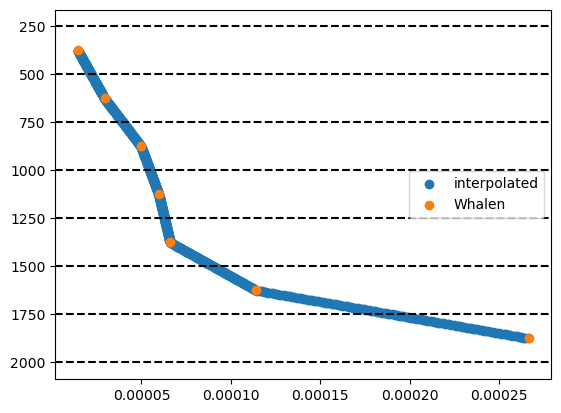

In [7]:
plt.scatter(K_rho.isel(lat_c=0).isel(lon_c=0), K_rho.z_c, label='interpolated')
plt.scatter(ds_diff.K.isel(lat_c=0).isel(lon_c=0), ds_diff.z_c, label='Whalen')
plt.gca().invert_yaxis()
for z in zs:
    plt.axhline(z, color='k', linestyle='--')
plt.legend()

In [8]:
start = 10**-6
end   = 10**-4
norm_k  = colors.LogNorm(vmin=start, vmax=end)
cmap  = cmo.dense_r

In [9]:
start = 10**-11
end   = 10**-8
norm_e  = colors.LogNorm(vmin=start, vmax=end)
cmap  = cmo.dense_r

In [10]:
depth = 1000

In [12]:
lon = -25

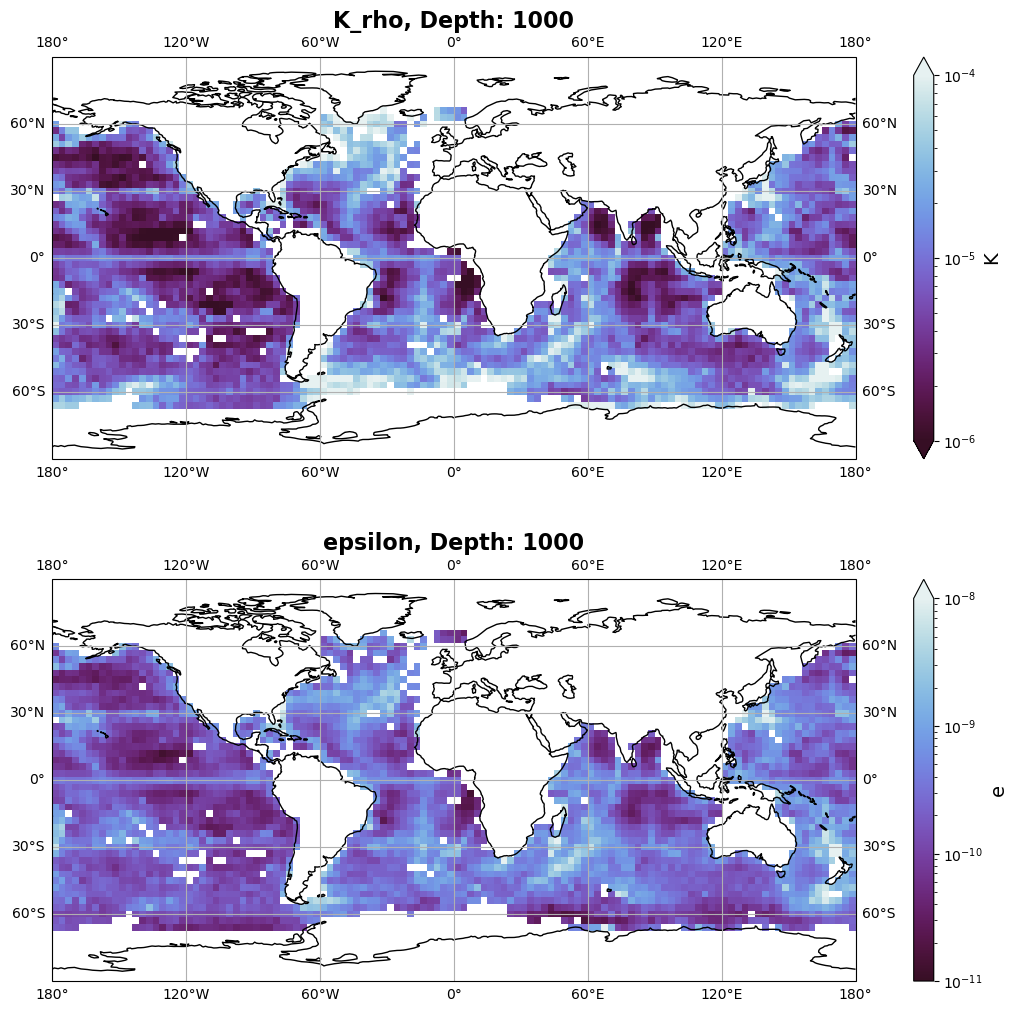

In [11]:
fig=plt.figure(figsize=(15,12))
ax1 = plt.subplot(211, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ax1.set_global()
K_rho.sel(z_c=depth, method='nearest').plot(x='lon_c',y='lat_c',ax=ax1,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm_k)
ax1.set_title('K_rho, Depth: {}'.format(K_rho.sel(z_c=depth, method='nearest').z_c.values));

ax2 = plt.subplot(212, projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.gridlines(draw_labels=True)
ax2.set_global()
e.sel(z_c=depth, method='nearest').plot(x='lon_c',y='lat_c',ax=ax2,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm_e)
ax2.set_title('epsilon, Depth: {}'.format(e.sel(z_c=depth, method='nearest').z_c.values))

plt.subplots_adjust(hspace=0.3)

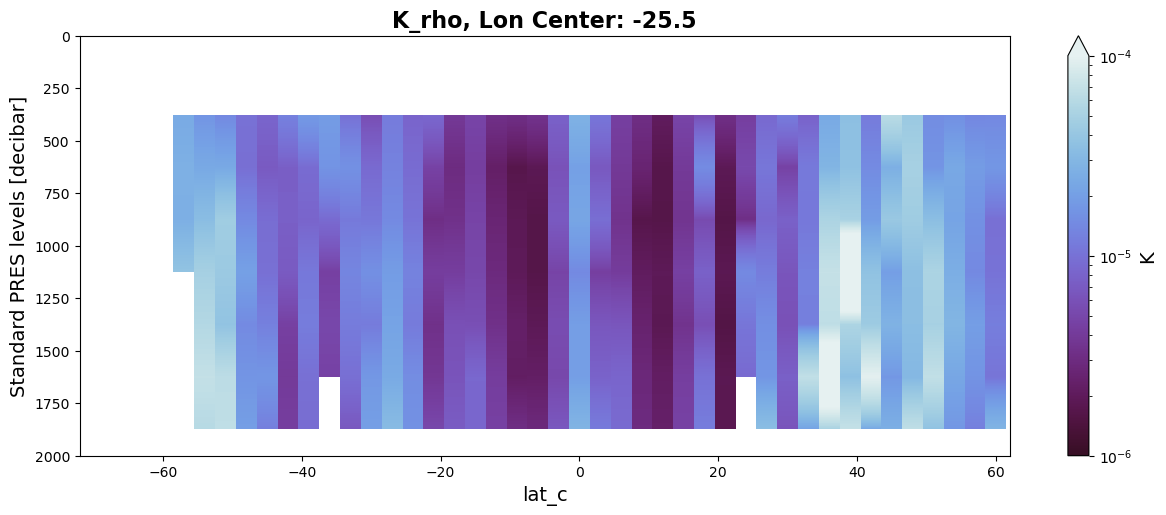

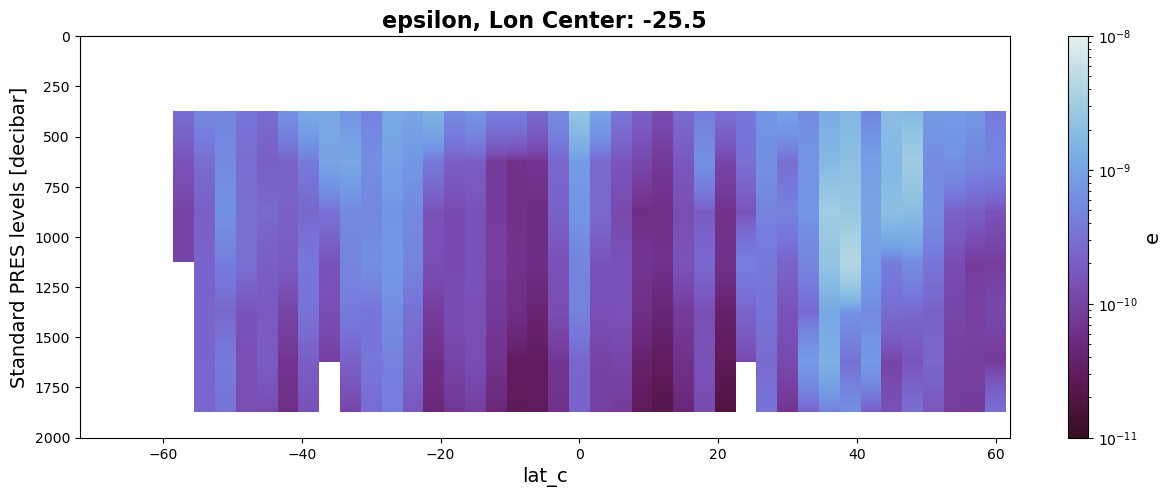

In [18]:
fig=plt.figure(figsize=(15,12))
plt.subplot(211)
K_rho.sel(lon_c=lon, method='nearest').plot(x='lat_c',y='z_c', cmap=cmap, norm=norm_k)
plt.gca().invert_yaxis()
plt.xlim(-72,62)
plt.title('K_rho, Lon Center: {}'.format(K_rho.sel(lon_c=lon, method='nearest').lon_c.values));

fig=plt.figure(figsize=(15,12))
plt.subplot(211)
e.sel(lon_c=lon, method='nearest').plot(x='lat_c',y='z_c', cmap=cmap, norm=norm_e)
plt.gca().invert_yaxis()
plt.xlim(-72,62)
plt.title('epsilon, Lon Center: {}'.format(K_rho.sel(lon_c=lon, method='nearest').lon_c.values));

plt.subplots_adjust(hspace=0.3)

### TEMPERATURE

In [ ]:
lfilt = 100

In [ ]:
ct_b = ds.CT
#sa_b = ds.SA
#sp_b = ds.SPICE

ct_m = ff.ds_filt_single(ds, lfilt, 'CT')
#sa_m = ff.ds_filt_single(ds, lfilt, 'SA')
#sp_m = ff.ds_filt_single(ds, lfilt, 'SPICE')

ct_e = ct_b - ct_m
#sa_e = sa_b - sa_m
#sp_e = sp_b - sp_m

In [ ]:
import psutil
print(f"Available memory: {psutil.virtual_memory().available / 1e9:.2f} GiB")

In [ ]:
ct_2 = K_rho*get_ds_binned(ff.da_filt_single((ct_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt), lon_bins, lat_bins)
#sa_2 = K_rho*get_ds_binned(ff.da_filt_single((sa_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt), lon_bins, lat_bins)
#sp_2 = K_rho*get_ds_binned(ff.da_filt_single((sp_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt), lon_bins, lat_bins)

ct_3 = K_rho*get_ds_binned((ct_m.differentiate(coord='PRES_INTERPOLATED'))**2, lon_bins, lat_bins)
#sa_3 = K_rho*get_ds_binned((sa_m.differentiate(coord='PRES_INTERPOLATED'))**2, lon_bins, lat_bins)
#sp_3 = K_rho*get_ds_binned((sp_m.differentiate(coord='PRES_INTERPOLATED'))**2, lon_bins, lat_bins)

In [ ]:
ct_tot  = ct_2 + ct_3
ct_2rat = ct_2/ct_tot
ct_3rat = ct_3/ct_tot

sa_tot  = sa_2 + sa_3
sa_2rat = sa_2/sa_tot
sa_3rat = sa_3/sa_tot

sp_tot  = sp_2 + sp_3
sp_2rat = sp_2/sp_tot
sp_3rat = sp_3/sp_tot

In [ ]:
print(ct_2.max().values, ct_2.min().values)

In [ ]:
ct_2.to_netcdf('/swot/SUM05/amf2288/sync_boxes/ct_2.nc')
ct_3.to_netcdf('/swot/SUM05/amf2288/sync_boxes/ct_3.nc')

In [ ]:
start = 10**-12
end   = 10**-8
norm  = colors-0987t5r645e4d3wsaq1`¸LogNorm(vmin=start, vmax=end)
cmap  = cmo.matter_r

In [ ]:
depth = 1000

In [ ]:
lon = -25

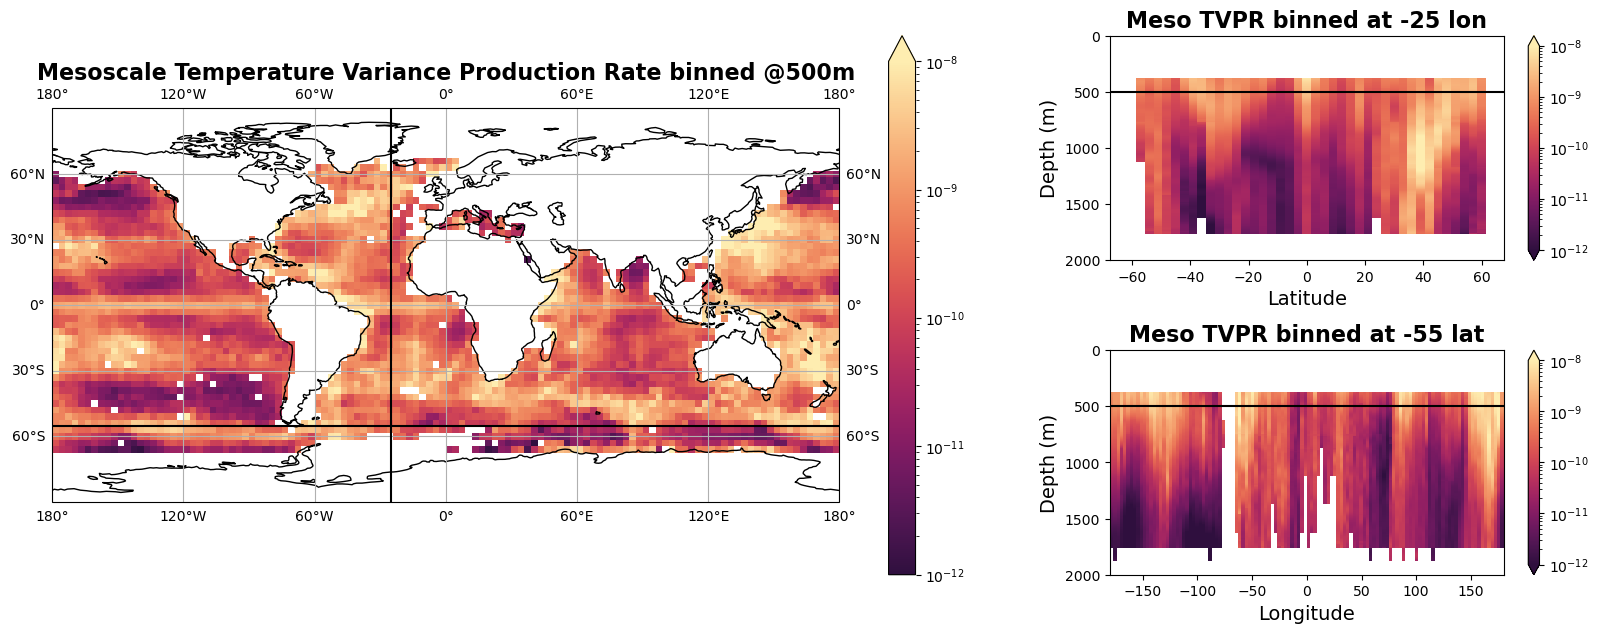

In [318]:
plt.figure(figsize=(20, 7))
gs = plt.GridSpec(2, 2, width_ratios=[2, 1])

ax1 = plt.subplot(gs[:, 0], projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ax1.axvline(lon, color='k')
ax1.axhline(lat, color='k')
ct_2.sel(z_c=depth, method='nearest').plot(x='lon_c', y='lat_c', ax=ax1, norm = norm, cmap=cmap)
ax1.set_title(f'Mesoscale Temperature Variance Production Rate binned @{depth}m')

ax2 = plt.subplot(gs[0, 1])
ct_2.sel(lon_c=lon, method='nearest').plot(x='lat_c', y='z_c', ax=ax2, norm = norm, cmap=cmap)
ax2.invert_yaxis()
ax2.axhline(depth, color='k')
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
ax2.set_title(f'Meso TVPR binned at {lon} lon')

ax4 = plt.subplot(gs[1, 1])
ct_2.sel(lat_c=lat, method='nearest').plot(x='lon_c', y='z_c', ax=ax4, norm = norm, cmap=cmap)
ax4.invert_yaxis()
ax4.axhline(depth, color='k')
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
ax4.set_title(f'Meso TVPR binned at {lat} lat')

plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.show()

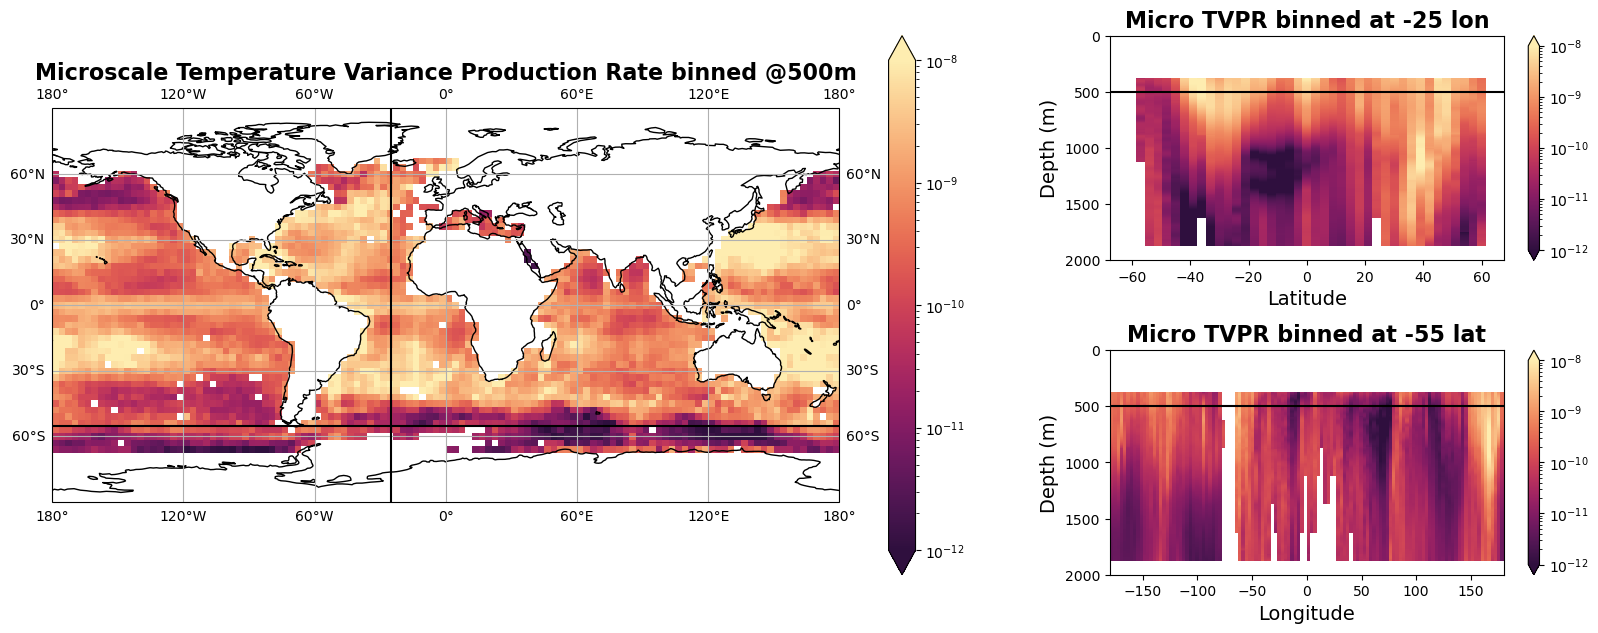

In [319]:
plt.figure(figsize=(20, 7))
gs = plt.GridSpec(2, 2, width_ratios=[2, 1])

ax1 = plt.subplot(gs[:, 0], projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ax1.axvline(lon, color='k')
ax1.axhline(lat, color='k')
ct_3.sel(z_c=depth, method='nearest').plot(x='lon_c', y='lat_c', ax=ax1, norm = norm, cmap=cmap)
ax1.set_title(f'Microscale Temperature Variance Production Rate binned @{depth}m')

ax2 = plt.subplot(gs[0, 1])
ct_3.sel(lon_c=lon, method='nearest').plot(x='lat_c', y='z_c', ax=ax2, norm = norm, cmap=cmap)
ax2.invert_yaxis()
ax2.axhline(depth, color='k')
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
ax2.set_title(f'Micro TVPR binned at {lon} lon')

ax4 = plt.subplot(gs[1, 1])
ct_3.sel(lat_c=lat, method='nearest').plot(x='lon_c', y='z_c', ax=ax4, norm = norm, cmap=cmap)
ax4.invert_yaxis()
ax4.axhline(depth, color='k')
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
ax4.set_title(f'Micro TVPR binned at {lat} lat')

plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.show()

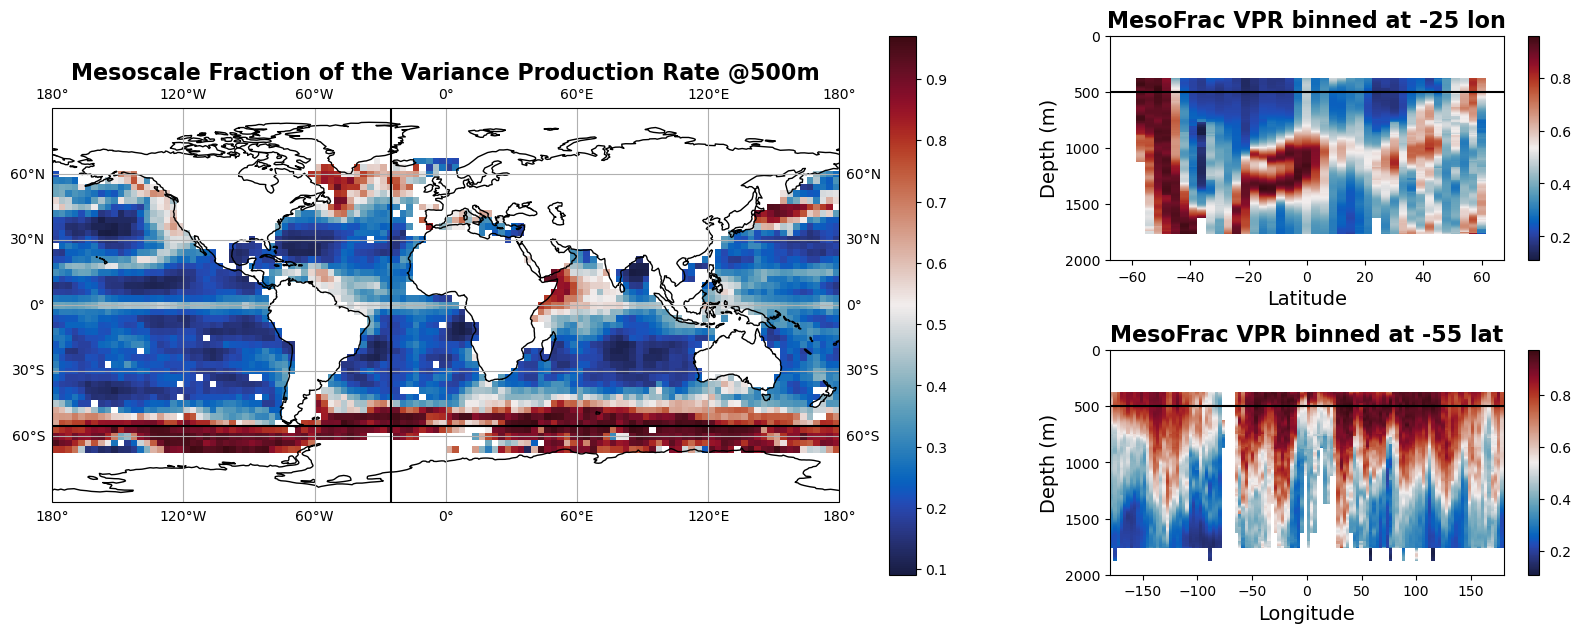

In [320]:
plt.figure(figsize=(20, 7))
gs = plt.GridSpec(2, 2, width_ratios=[2, 1])

ax1 = plt.subplot(gs[:, 0], projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ax1.axvline(lon, color='k')
ax1.axhline(lat, color='k')
ct_2rat.sel(z_c=depth, method='nearest').plot(x='lon_c', y='lat_c', ax=ax1, cmap=cmo.balance)
ax1.set_title(f'Mesoscale Fraction of the Variance Production Rate @{depth}m')

ax2 = plt.subplot(gs[0, 1])
ct_2rat.sel(lon_c=lon, method='nearest').plot(x='lat_c', y='z_c', ax=ax2, cmap=cmo.balance)
ax2.invert_yaxis()
ax2.axhline(depth, color='k')
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
ax2.set_title(f'MesoFrac VPR binned at {lon} lon')

ax4 = plt.subplot(gs[1, 1])
ct_2rat.sel(lat_c=lat, method='nearest').plot(x='lon_c', y='z_c', ax=ax4, cmap=cmo.balance)
ax4.invert_yaxis()
ax4.axhline(depth, color='k')
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
ax4.set_title(f'MesoFrac VPR binned at {lat} lat')

plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.show()

## Calculate Variance, step-by-step

In [ ]:
lfilter = 100

In [ ]:
depth = 500
lon = -25
lat = -55

In [ ]:
depth = 500
lon = -25
lat = -55

In [ ]:
ct_var = get_ds_binned(ds.CT**2, lon_bins, lat_bins).compute()

In [ ]:
plt.figure(figsize=(20, 7))
gs = plt.GridSpec(2, 2, width_ratios=[2, 1])

ax1 = plt.subplot(gs[:, 0], projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ax1.axvline(lon, color='k')
ax1.axhline(lat, color='k')
ct_var.sel(z_c=depth, method='nearest').plot(x='lon_c', y='lat_c', ax=ax1, cmap=cmo.deep_r, robust=True)
ax1.set_title(f'binned @{depth}m')

ax2 = plt.subplot(gs[0, 1])
ct_var.sel(lon_c=lon, method='nearest').plot(x='lat_c', y='z_c', ax=ax2, cmap=cmo.deep_r, robust=True)
ax2.invert_yaxis()
ax2.axhline(depth, color='k')
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
ax2.set_title(f'binned at {lon} lon')

ax4 = plt.subplot(gs[1, 1])
ct_var.sel(lat_c=lat, method='nearest').plot(x='lon_c', y='z_c', ax=ax4, cmap=cmo.deep_r, robust=True)
ax4.invert_yaxis()
ax4.axhline(depth, color='k')
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
ax4.set_title(f'binned at {lat} lat')

plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.show()

In [ ]:
ct_e_var        = (ds.CT - ff.da_filt_single(ds.CT, lfilter))**2
ct_e_var_binned = get_ds_binned(ct_e_var, lon_bins, lat_bins).compute()

In [ ]:
ct_m_var        = (ff.da_filt_single(ds.CT, lfilter))**2
ct_m_var_binned = get_ds_binned(ct_m_var, lon_bins, lat_bins).compute()

In [ ]:
e_start = 1e-2
e_end   = 1e-4
e_norm  = colors.LogNorm(vmin=e_start, vmax=e_end)
e_cmap  = cmo.deep_r

In [ ]:
lat = -45

In [ ]:
plt.figure(figsize=(20, 7))
gs = plt.GridSpec(2, 2, width_ratios=[2, 1])

ax1 = plt.subplot(gs[:, 0], projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ax1.axvline(lon, color='k')
ax1.axhline(lat, color='k')
ct_e_var_binned.sel(z_c=depth, method='nearest').plot(x='lon_c', y='lat_c', ax=ax1, norm=e_norm, cmap=e_cmap)
ax1.set_title(f'Mesoscale Temperature Variance binned @{depth}m')

ax2 = plt.subplot(gs[0, 1])
ct_e_var_binned.sel(lon_c=lon, method='nearest').plot(x='lat_c', y='z_c', ax=ax2, norm=e_norm, cmap=e_cmap)
ax2.invert_yaxis()
ax2.axhline(depth, color='k')
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
ax2.set_title(f'Meso TV binned at {lon} lon')

ax4 = plt.subplot(gs[1, 1])
ct_e_var_binned.sel(lat_c=lat, method='nearest').plot(x='lon_c', y='z_c', ax=ax4, norm=e_norm, cmap=e_cmap)
ax4.invert_yaxis()
ax4.axhline(depth, color='k')
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
ax4.set_title(f'Meso TV binned at {lat} lat')

plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.show()

In [ ]:
m_start = 100
m_end   = 5
m_norm  = colors.LogNorm(vmin=m_start, vmax=m_end)

In [ ]:
ct_e_diff_var = get_ds_binned(ff.da_filt_single(((ds.CT-ff.da_filt_single(ds.CT, lfilter)).differentiate(coord='PRES_INTERPOLATED'))**2, lfilter), lon_bins, lat_bins).compute()

In [ ]:
diff_start = 1e-6
diff_end   = 1e-3
diff_norm  = colors.LogNorm(vmin=diff_start, vmax=diff_end)

In [ ]:
plt.figure(figsize=(20, 7))
gs = plt.GridSpec(2, 2, width_ratios=[2, 1])

ax1 = plt.subplot(gs[:, 0], projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ax1.axvline(lon, color='k')
ax1.axhline(lat, color='k')
ct_e_diff_var.sel(z_c=depth, method='nearest').plot(x='lon_c', y='lat_c', ax=ax1, cmap=cmo.matter_r, norm=diff_norm)
ax1.set_title(f'binned @{depth}m')

ax2 = plt.subplot(gs[0, 1])
ct_e_diff_var.sel(lon_c=lon, method='nearest').plot(x='lat_c', y='z_c', ax=ax2, cmap=cmo.matter_r, norm=diff_norm)
ax2.invert_yaxis()
ax2.axhline(depth, color='k')
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
ax2.set_title(f'binned at {lon} lon')

ax4 = plt.subplot(gs[1, 1])
ct_e_diff_var.sel(lat_c=lat, method='nearest').plot(x='lon_c', y='z_c', ax=ax4, cmap=cmo.matter_r, norm=diff_norm)
ax4.invert_yaxis()
ax4.axhline(depth, color='k')
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
ax4.set_title(f'binned at {lat} lat')

plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.show()

# FYC Slides / argo_figs

Tried to make a seperate notebook for these plots, but ran into memory issues which I didn't encounter here and also didn't really want to spend a ton of time figuring out.

Now I'm commandeering this section for my argo_figs printouts

In [ ]:
ct_2 = xr.open_DataArray('/swot/SUM05/amf2288/var-boxes/ct_2_3.nc')
ct_3 = xr.open_DataArray('/swot/SUM05/amf2288/var-boxes/ct_3_3.nc')

sa_2 = xr.open_DataArray('/swot/SUM05/amf2288/var-boxes/sa_2_3.nc')
sa_3 = xr.open_DataArray('/swot/SUM05/amf2288/var-boxes/sa_3_3.nc')

sp_2 = xr.open_DataArray('/swot/SUM05/amf2288/var-boxes/sp_2_3.nc')
sp_3 = xr.open_DataArray('/swot/SUM05/amf2288/var-boxes/sp_3_3.nc')

In [ ]:
ct_2rat = xr.open_DataArray('/swot/SUM05/amf2288/var-boxes/ct_2rat_3.nc')
ct_3rat = xr.open_DataArray('/swot/SUM05/amf2288/var-boxes/ct_3rat_3.nc')

sa_2rat = xr.open_DataArray('/swot/SUM05/amf2288/var-boxes/sa_2rat_3.nc')
sa_3rat = xr.open_DataArray('/swot/SUM05/amf2288/var-boxes/sa_3rat_3.nc')

sp_2rat = xr.open_DataArray('/swot/SUM05/amf2288/var-boxes/sp_2rat_3.nc')
sp_3rat = xr.open_DataArray('/swot/SUM05/amf2288/var-boxes/sp_3rat_3.nc')

In [ ]:
depth = 1000

In [ ]:
lon = -25

In [ ]:
var_start = 10**-12
var_end   = 10**-8
var_norm  = colors.LogNorm(vmin=var_start, vmax=var_end)
var_cmap  = cmo.matter_r

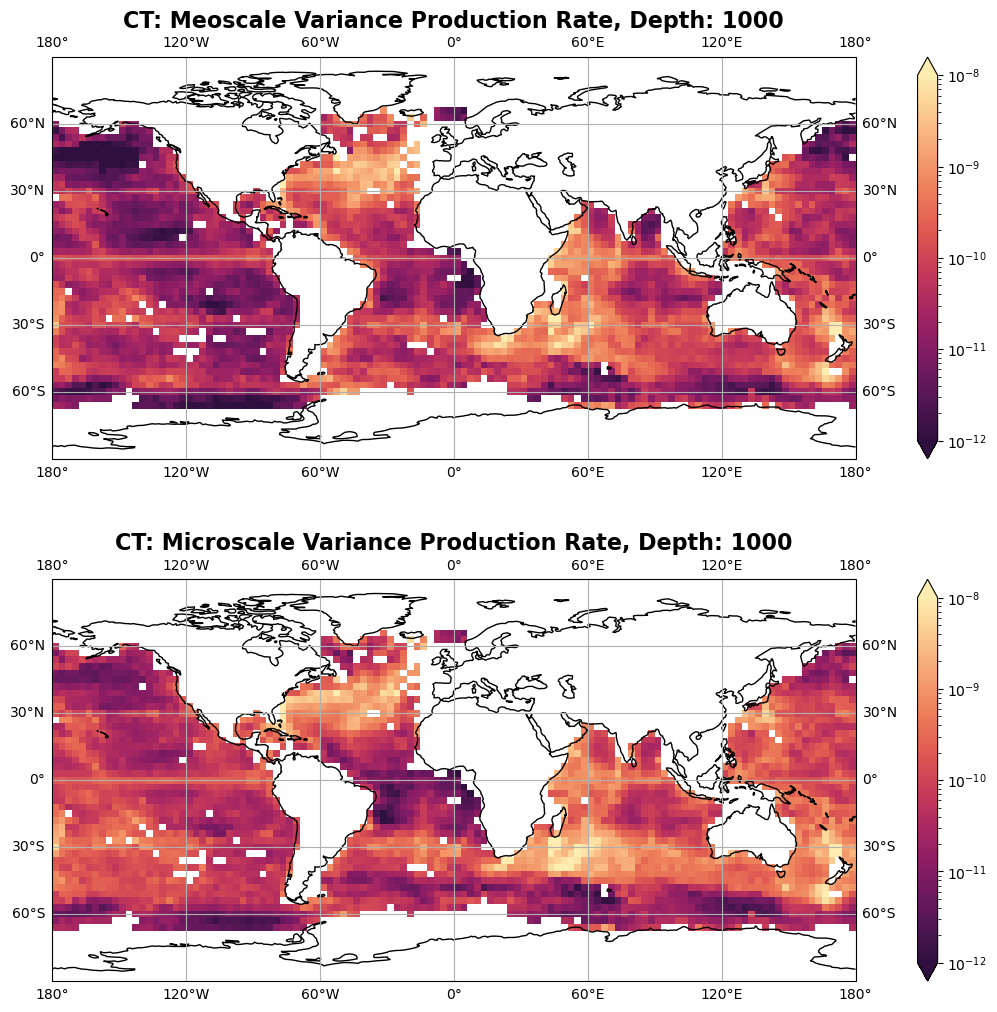

In [323]:
fig=plt.figure(figsize=(16,12))
ax1 = plt.subplot(211, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ax1.set_global()
ct_2.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax1,transform=ccrs.PlateCarree(), norm=var_norm, cmap=var_cmap)
ax1.set_title('CT: Meoscale Variance Production Rate, Depth: {}'.format(ct_2.sel(z_c=depth).z_c.values))

ax2 = plt.subplot(212, projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.gridlines(draw_labels=True)
ax2.set_global()
ct_3.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax2,transform=ccrs.PlateCarree(), norm=var_norm, cmap=var_cmap)
ax2.set_title('CT: Microscale Variance Production Rate, Depth: {}'.format(ct_2.sel(z_c=depth).z_c.values))

plt.subplots_adjust(hspace=0.3)

In [ ]:
fig=plt.figure(figsize=(15,12))
plt.subplot(211)
ct_2.sel(lon_c=lon).plot(x='lat_c',y='z_c', norm=var_norm, cmap=var_cmap)
plt.gca().invert_yaxis()
plt.xlim(-72,62)
plt.title('CT: Meoscale Variance Production Rate, Lon Center: {}'.format(ct_2.sel(lon_c=lon).lon_c.values))

fig=plt.figure(figsize=(15,12))
plt.subplot(211)
ct_3.sel(lon_c=lon).plot(x='lat_c',y='z_c', norm=var_norm, cmap=var_cmap)
plt.gca().invert_yaxis()
plt.xlim(-72,62)
plt.title('CT: Microscale Variance Production Rate, Lon Center: {}'.format(ct_2.sel(lon_c=lon).lon_c.values))

plt.subplots_adjust(hspace=0.3)

In [324]:
var_start = 10**-14
var_end   = 10**-10
var_norm  = colors.LogNorm(vmin=var_start, vmax=var_end)
var_cmap  = cmo.matter_r

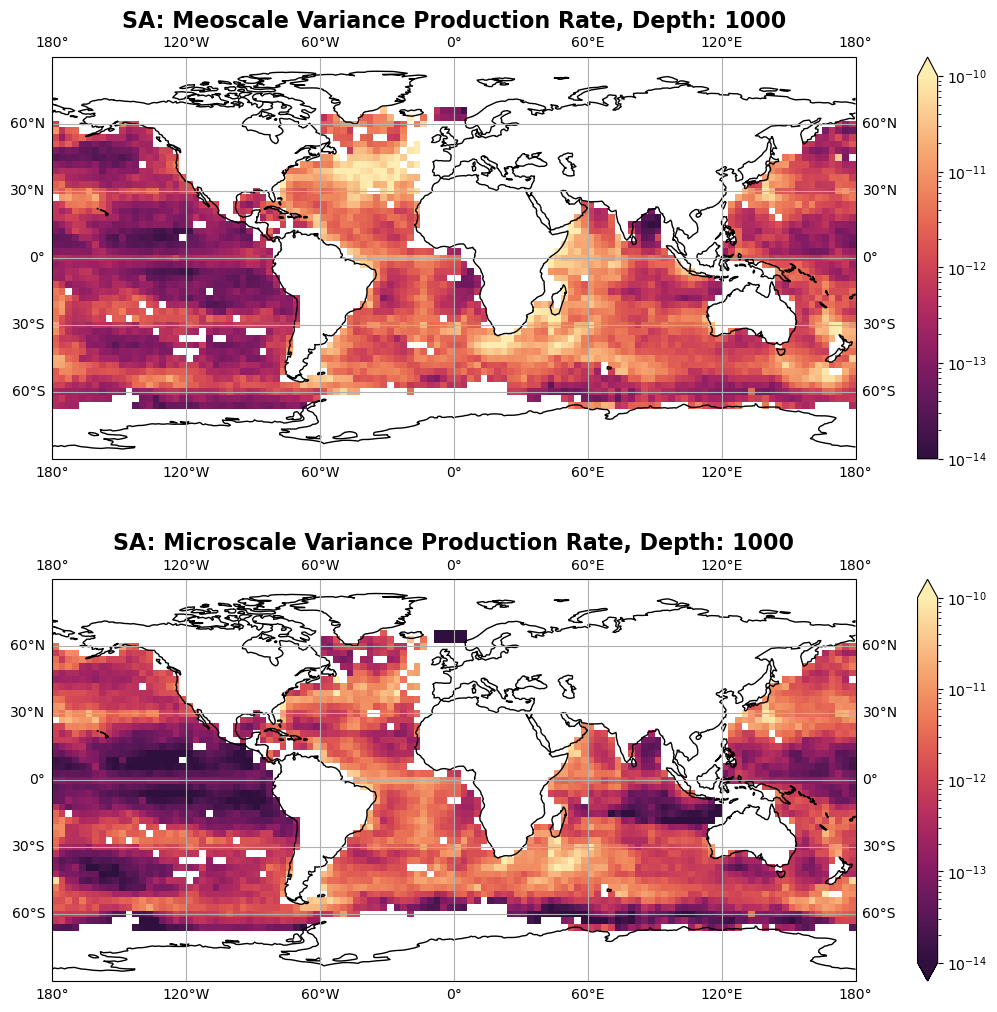

In [325]:
fig=plt.figure(figsize=(16,12))
ax1 = plt.subplot(211, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ax1.set_global()
sa_2.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax1,transform=ccrs.PlateCarree(), norm=var_norm, cmap=var_cmap)
ax1.set_title('SA: Meoscale Variance Production Rate, Depth: {}'.format(ct_2.sel(z_c=depth).z_c.values))

ax2 = plt.subplot(212, projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.gridlines(draw_labels=True)
ax2.set_global()
sa_3.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax2,transform=ccrs.PlateCarree(), norm=var_norm, cmap=var_cmap)
ax2.set_title('SA: Microscale Variance Production Rate, Depth: {}'.format(ct_2.sel(z_c=depth).z_c.values))

plt.subplots_adjust(hspace=0.3)

In [ ]:
fig=plt.figure(figsize=(15,12))
plt.subplot(211)
sa_2.sel(lon_c=lon).plot(x='lat_c',y='z_c', norm=var_norm, cmap=var_cmap)
plt.gca().invert_yaxis()
plt.xlim(-72,62)
plt.title('SA: Meoscale Variance Production Rate, Lon Center: {}'.format(ct_2.sel(lon_c=lon).lon_c.values))

fig=plt.figure(figsize=(15,12))
plt.subplot(211)
sa_3.sel(lon_c=lon).plot(x='lat_c',y='z_c', norm=var_norm, cmap=var_cmap)
plt.gca().invert_yaxis()
plt.xlim(-72,62)
plt.title('SA: Microscale Variance Production Rate, Lon Center: {}'.format(ct_2.sel(lon_c=lon).lon_c.values))

plt.subplots_adjust(hspace=0.3)

In [326]:
var_start = 10**-14
var_end   = 10**-10
var_norm  = colors.LogNorm(vmin=var_start, vmax=var_end)
var_cmap  = cmo.matter_r

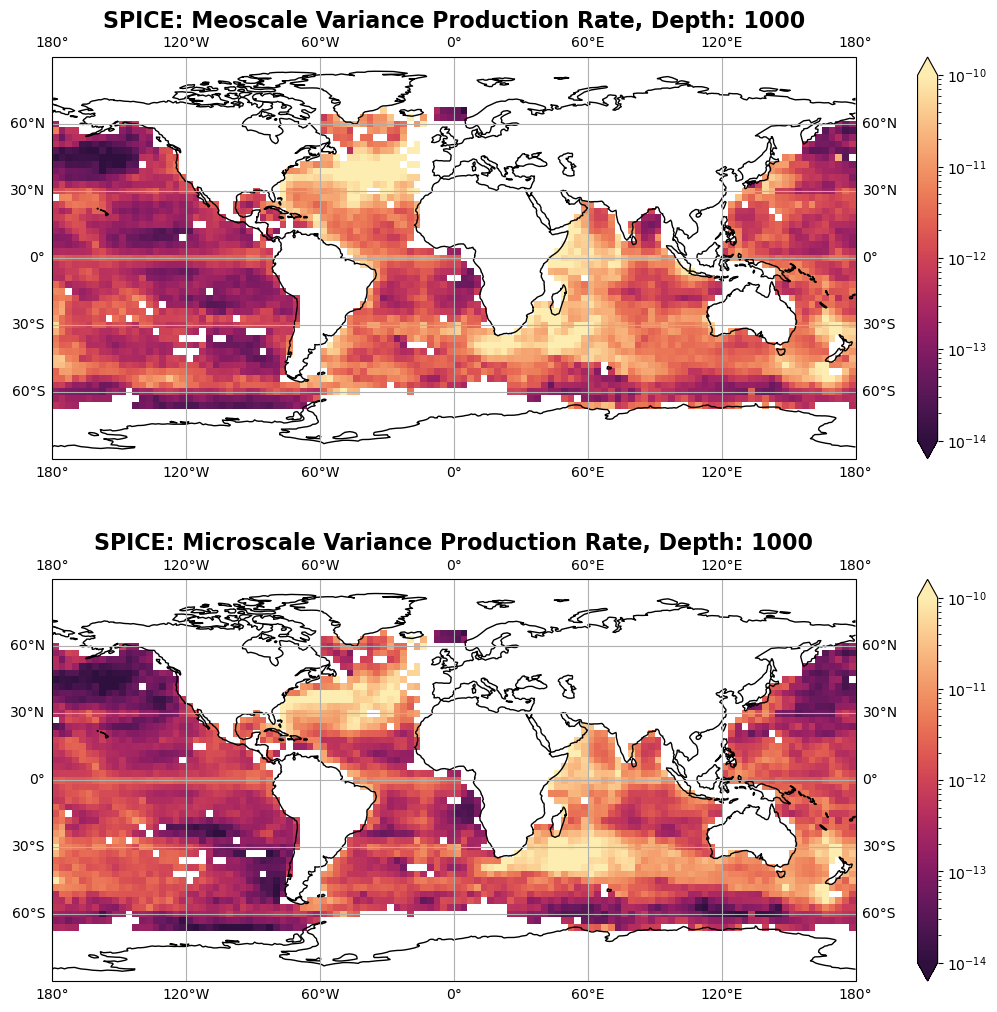

In [327]:
fig=plt.figure(figsize=(16,12))
ax1 = plt.subplot(211, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ax1.set_global()
sp_2.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax1,transform=ccrs.PlateCarree(), norm=var_norm, cmap=var_cmap)
ax1.set_title('SPICE: Meoscale Variance Production Rate, Depth: {}'.format(ct_2.sel(z_c=depth).z_c.values))

ax2 = plt.subplot(212, projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.gridlines(draw_labels=True)
ax2.set_global()
sp_3.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax2,transform=ccrs.PlateCarree(), norm=var_norm, cmap=var_cmap)
ax2.set_title('SPICE: Microscale Variance Production Rate, Depth: {}'.format(ct_2.sel(z_c=depth).z_c.values))

plt.subplots_adjust(hspace=0.3)

In [ ]:
fig=plt.figure(figsize=(15,12))
plt.subplot(211)
sp_2.sel(lon_c=lon).plot(x='lat_c',y='z_c', norm=var_norm, cmap=var_cmap)
plt.gca().invert_yaxis()
plt.xlim(-72,62)
plt.title('SPICE: Meoscale Variance Production Rate, Lon Center: {}'.format(ct_2.sel(lon_c=lon).lon_c.values))

fig=plt.figure(figsize=(15,12))
plt.subplot(211)
sp_3.sel(lon_c=lon).plot(x='lat_c',y='z_c', norm=var_norm, cmap=var_cmap)
plt.gca().invert_yaxis()
plt.xlim(-72,62)
plt.title('SPICE: Microscale Variance Production Rate, Lon Center: {}'.format(ct_2.sel(lon_c=lon).lon_c.values))

plt.subplots_adjust(hspace=0.3)

In [328]:
cmap = cmo.balance

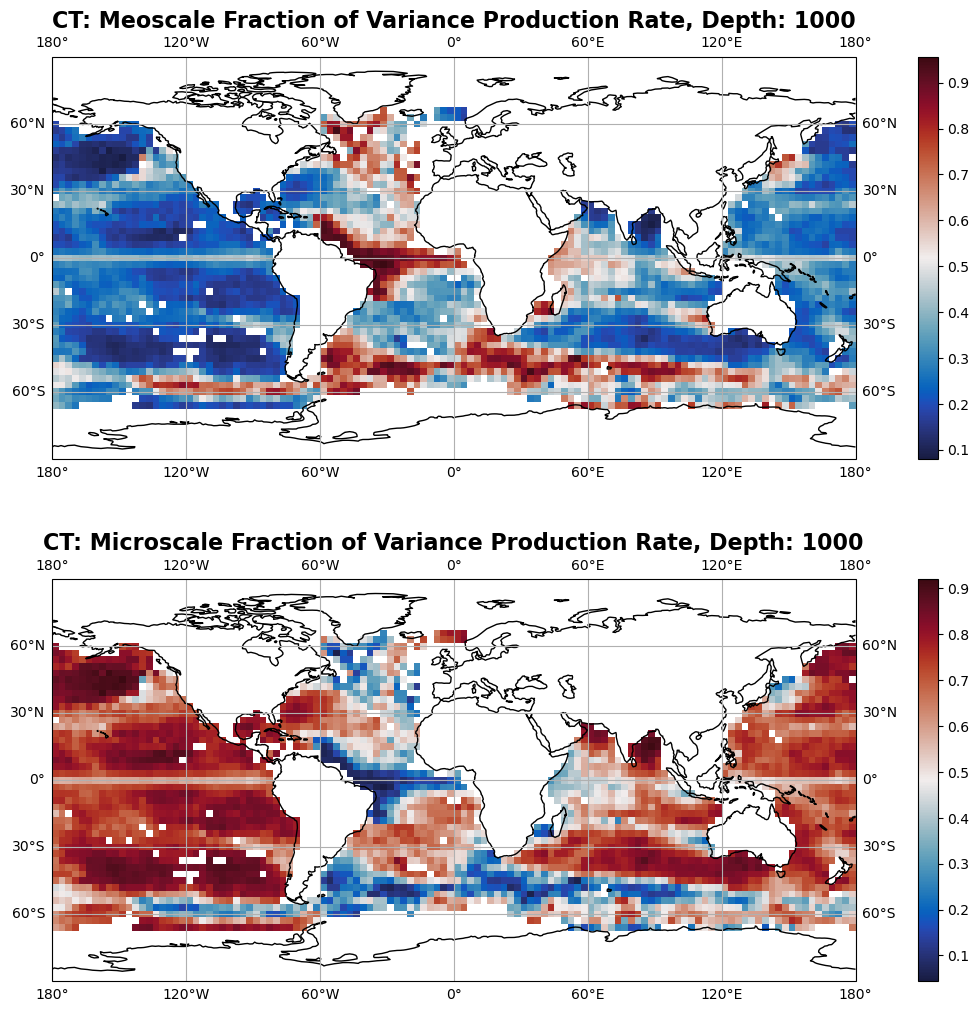

In [329]:
fig=plt.figure(figsize=(15,12))
ax1 = plt.subplot(211, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ax1.set_global()
ct_2rat.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax1,transform=ccrs.PlateCarree(), cmap=cmap)
ax1.set_title('CT: Meoscale Fraction of Variance Production Rate, Depth: {}'.format(ct_2.sel(z_c=depth).z_c.values))

ax2 = plt.subplot(212, projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.gridlines(draw_labels=True)
ax2.set_global()
ct_3rat.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax2,transform=ccrs.PlateCarree(), cmap=cmap)
ax2.set_title('CT: Microscale Fraction of Variance Production Rate, Depth: {}'.format(ct_2.sel(z_c=depth).z_c.values))

plt.subplots_adjust(hspace=0.3)

In [ ]:
fig=plt.figure(figsize=(15,12))
plt.subplot(211)
ct_2rat.sel(lon_c=lon).plot(x='lat_c',y='z_c',cmap=cmap, vmin=0, vmax=1)
ax1.set_title('CT: Meoscale Fraction of Variance Production Rate, Depth: {}'.format(ct_2.sel(lon_c=lon).lon_c.values))

ax2 = plt.subplot(212)
plt.subplot(211)
ct_3rat.sel(lon_c=lon).plot(x='lat_c',y='z_c',cmap=cmap, vmin=0, vmax=1)
ax1.set_title('CT: Microscale Fraction of Variance Production Rate, Depth: {}'.format(ct_2.sel(lon_c=lon).lon_c.values))
plt.subplots_adjust(hspace=0.3)

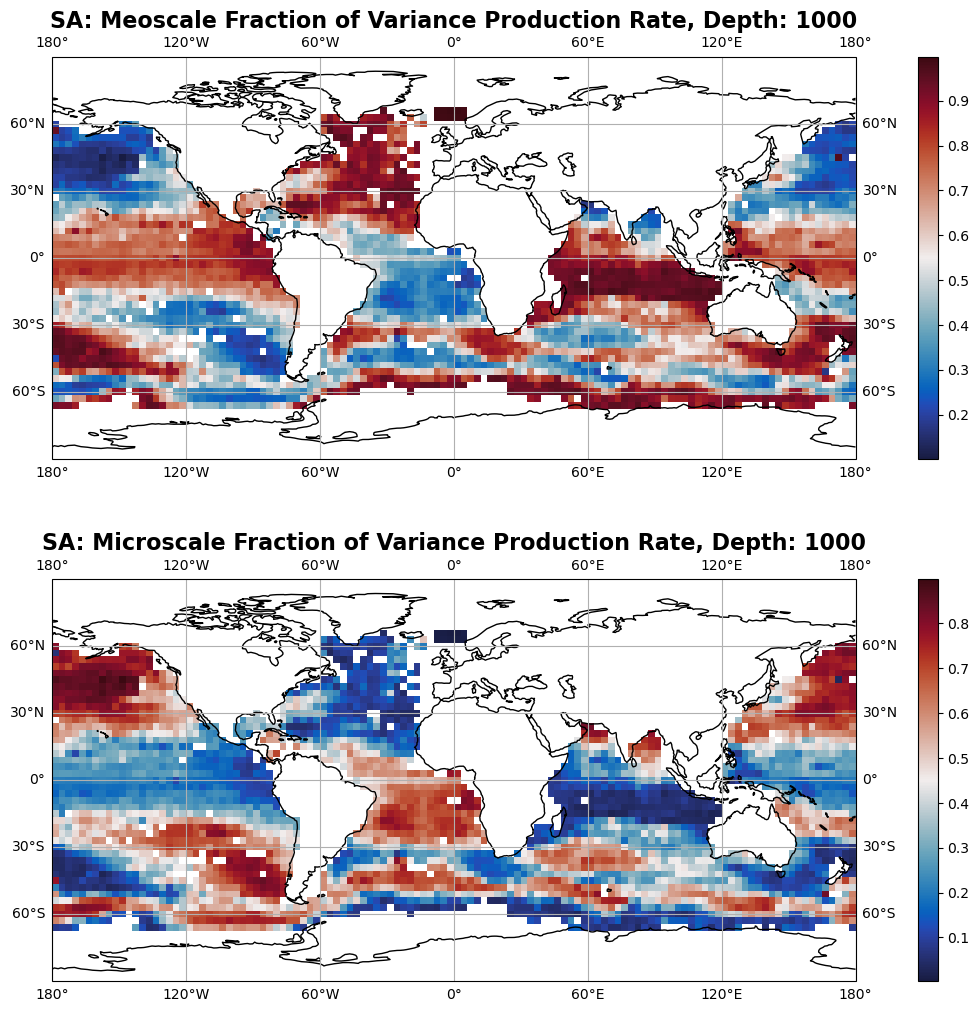

In [330]:
fig=plt.figure(figsize=(15,12))
ax1 = plt.subplot(211, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ax1.set_global()
sa_2rat.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax1,transform=ccrs.PlateCarree(), cmap=cmap)
ax1.set_title('SA: Meoscale Fraction of Variance Production Rate, Depth: {}'.format(ct_2.sel(z_c=depth).z_c.values))

ax2 = plt.subplot(212, projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.gridlines(draw_labels=True)
ax2.set_global()
sa_3rat.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax2,transform=ccrs.PlateCarree(), cmap=cmap)
ax2.set_title('SA: Microscale Fraction of Variance Production Rate, Depth: {}'.format(ct_2.sel(z_c=depth).z_c.values))

plt.subplots_adjust(hspace=0.3)

In [ ]:
fig=plt.figure(figsize=(15,12))
plt.subplot(211)
sa_2rat.sel(lon_c=lon).plot(x='lat_c',y='z_c',cmap=cmap, vmin=0, vmax=1)
ax1.set_title('SA: Meoscale Fraction of Variance Production Rate, Depth: {}'.format(ct_2.sel(lon_c=lon).lon_c.values))

ax2 = plt.subplot(212)
plt.subplot(211)
sa_3rat.sel(lon_c=lon).plot(x='lat_c',y='z_c',cmap=cmap, vmin=0, vmax=1)
ax1.set_title('SA: Microscale Fraction of Variance Production Rate, Depth: {}'.format(ct_2.sel(lon_c=lon).lon_c.values))
plt.subplots_adjust(hspace=0.3)

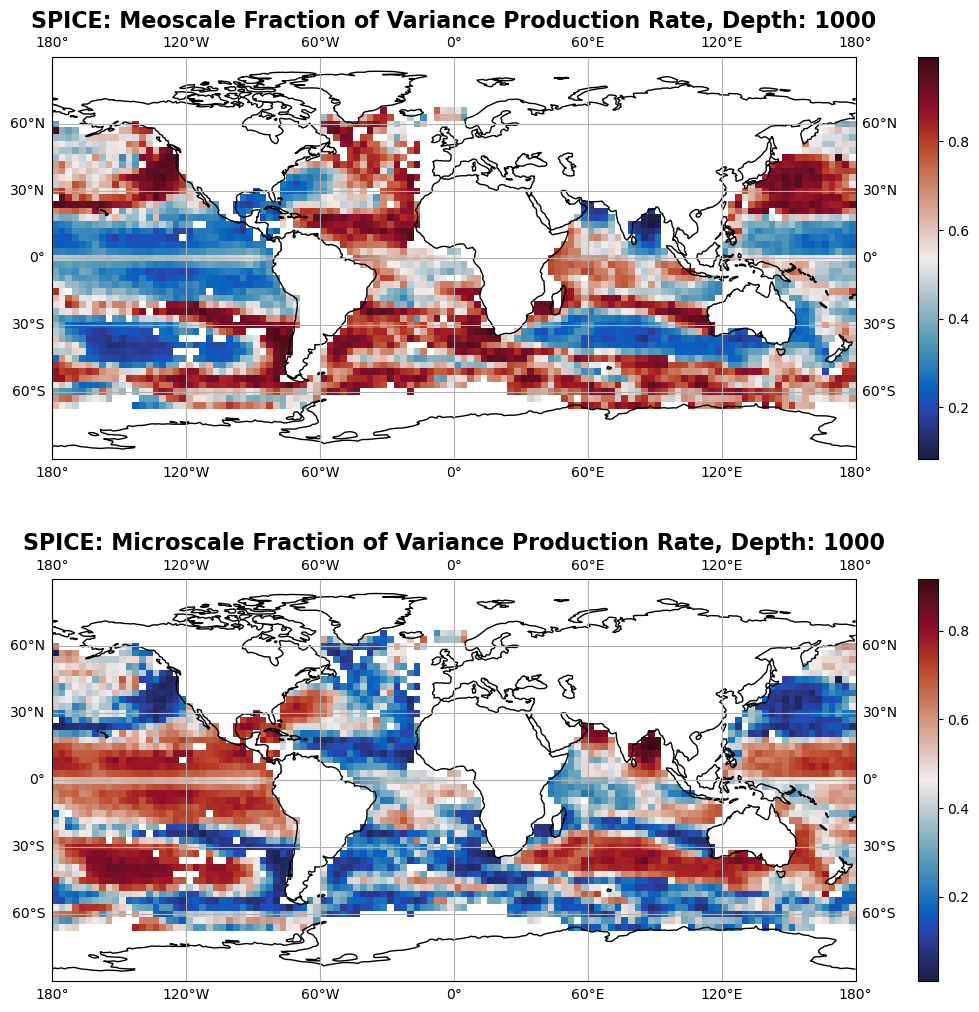

In [331]:
fig=plt.figure(figsize=(16,12))
ax1 = plt.subplot(211, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ax1.set_global()
sp_2rat.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax1,transform=ccrs.PlateCarree(), cmap=cmap)
ax1.set_title('SPICE: Meoscale Fraction of Variance Production Rate, Depth: {}'.format(ct_2.sel(z_c=depth).z_c.values))

ax2 = plt.subplot(212, projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.gridlines(draw_labels=True)
ax2.set_global()
sp_3rat.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax2,transform=ccrs.PlateCarree(), cmap=cmap)
ax2.set_title('SPICE: Microscale Fraction of Variance Production Rate, Depth: {}'.format(ct_2.sel(z_c=depth).z_c.values))

plt.subplots_adjust(hspace=0.3)

In [ ]:
fig=plt.figure(figsize=(15,12))
plt.subplot(211)
sp_2rat.sel(lon_c=lon).plot(x='lat_c',y='z_c',cmap=cmap, vmin=0, vmax=1)
ax1.set_title('SPICE: Meoscale Fraction of Variance Production Rate, Depth: {}'.format(ct_2.sel(lon_c=lon).lon_c.values))

ax2 = plt.subplot(212)
plt.subplot(211)
sp_3rat.sel(lon_c=lon).plot(x='lat_c',y='z_c',cmap=cmap, vmin=0, vmax=1)
ax1.set_title('SPICE: Microscale Fraction of Variance Production Rate, Depth: {}'.format(ct_2.sel(lon_c=lon).lon_c.values))
plt.subplots_adjust(hspace=0.3)

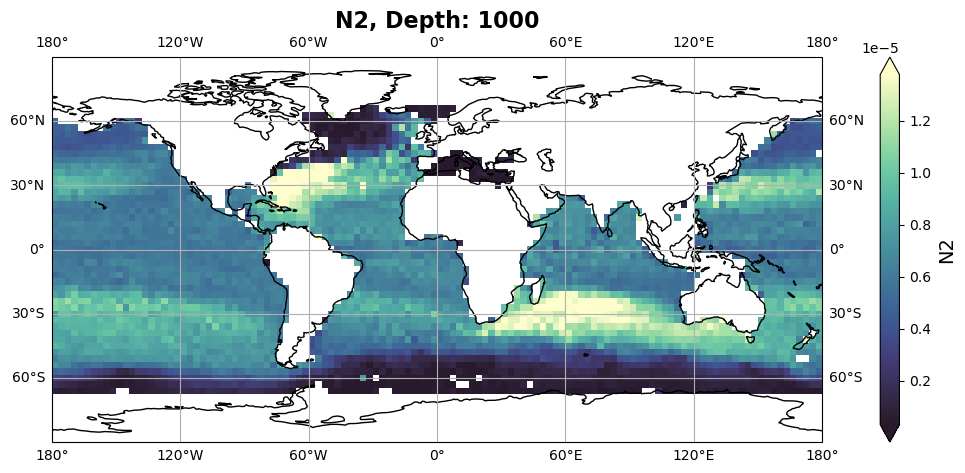

In [334]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds_binned.N2.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, robust=True)
ax.set_title('N2, Depth: {}'.format(ds_binned.sel(z_c=depth).z_c.values));